## Imports and Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import calib_utils
from utils import post_utils
from utils import config_utils
from utils import eval_utils
from utils import model_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [113]:
iso_code = "SEN"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AS.yaml")
config_file = os.path.join(os.getcwd(), "configs/best_models.yaml")
data_config = config_utils.load_config(data_config_file)
config = config_utils.create_config(config_file)

## Load Validation Results

In [114]:
val_output = model_utils.ensemble_models(iso_code, config, phase="val")
test_output = model_utils.ensemble_models(iso_code, config, phase="test")
print(test_output.shape)
test_output.head(3)

(1888, 18)


,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-SEN-SCHOOL-00000075,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole d'Elinkine,NaN,0,0.0,school,13,rural,test,POINT (-1645442.8880473897 1541725.5277999148),1,1,0.953690
1,OSM-SEN-SCHOOL-00000161,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole 1,NaN,0,0.0,school,23,urban,test,POINT (-1319954.9528390914 1954650.5035527328),1,1,0.960500
2,OSM-SEN-SCHOOL-00000185,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole Elémentaire Tivaouane 13,NaN,0,0.0,school,30,urban,test,POINT (-1648856.406144037 1841900.0392739468),1,1,0.941142


## Load Evaluation

In [115]:
val_results = eval_utils.evaluate(
    y_true=val_output["y_true"], 
    y_pred=val_output["y_preds"], 
    y_prob=val_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2
)
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results;

In [64]:
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=1,
    optim_threshold=0.5
)
test_results

{'auprc': 0.9942724347749214,
 'ap': 0.9942724347749214,
 'roc_auc': 0.996959187363369,
 'brier_score': 0.027327664079277038,
 'precision_scores_': array([0.34188433, 0.34204386, 0.34220355, ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.        , 1.        , 1.        , ..., 0.00272851, 0.00136426,
        0.        ]),
 'thresholds_': array([0.03351351, 0.03559736, 0.03569594, ..., 0.97537426, 0.9766132 ,
        0.9781913 ]),
 'optim_threshold': 0.5,
 'fbeta_score': 95.50408719346049,
 'precision_score': 95.37414965986395,
 'recall_score': 95.63437926330151,
 'overall_accuracy': 96.92164179104478,
 'balanced_accuracy': 96.61237035454232}

In [65]:
preds = [int(x) for x in list(test_output['y_probs'] > 0.5)]
cm, cm_metrics, cm_report = eval_utils.get_confusion_matrix(
    test_output['y_true'], preds, [1, 0]
)
cm

,1,0
1,701,32
0,34,1377


In [68]:
test_output[test_output['class'] == "school"].shape

(733, 19)

In [43]:
print(cm_metrics)

   precision     recall   f1_score
0  97.728886  97.590361  97.659574
1  95.374150  95.634379  95.504087


### Per-country Regional Model Results

In [ ]:
test_output_sub = test_output[test_output["iso"] == "ZWE"]
test_results = eval_utils.evaluate(
    y_true=test_output_sub["y_true"], 
    y_pred=test_output_sub["y_preds"], 
    y_prob=test_output_sub["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results

## Plot Results

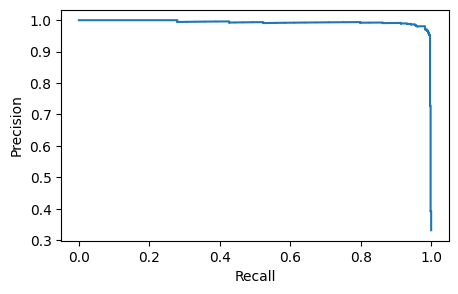

In [124]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

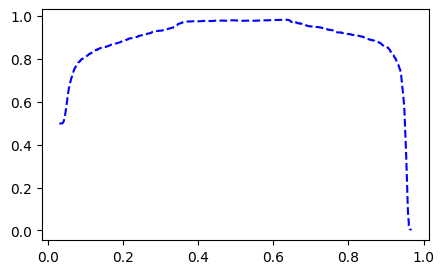

In [123]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['pr_thresholds'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['pr_thresholds'], test_fscores[:-1], "b--");

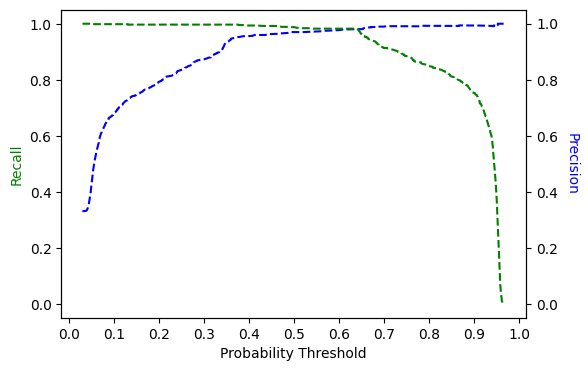

In [158]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(test_results['pr_thresholds'], test_results['precision_scores_'][:-1], "b--")
ax.plot(test_results['pr_thresholds'], test_results['recall_scores_'][:-1], "g--");
ax.set_ylabel("Recall")
ax.yaxis.label.set_color('green')
ax2 = ax.twinx()
l = ax.get_ylim()
l2 = ax2.get_ylim()
f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
ticks = f(ax.get_yticks())
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
ax2.set_yticklabels(ax.get_yticklabels())
ax2.set_ylabel("Precision", rotation=270, labelpad=15)
ax2.yaxis.label.set_color('blue')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax.set_xlabel("Probability Threshold")
loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

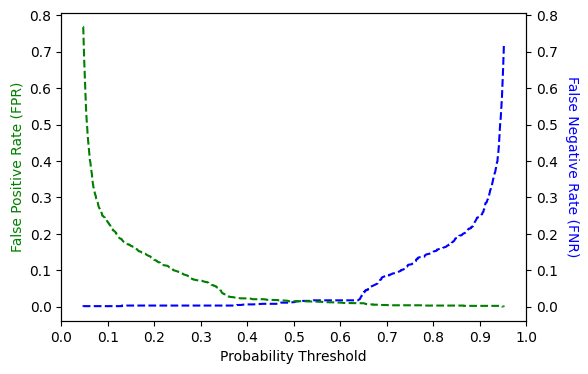

In [159]:
import matplotlib
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(test_results['det_thresholds'], test_results['fnr'], "b--")
ax.plot(test_results['det_thresholds'], test_results['fpr'], "g--");

ax.set_ylabel("False Positive Rate (FPR)")
ax.yaxis.label.set_color('green')
ax2 = ax.twinx()
l = ax.get_ylim()
l2 = ax2.get_ylim()
f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
ticks = f(ax.get_yticks())
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
ax2.set_yticklabels(ax.get_yticklabels())
ax2.set_ylabel("False Negative Rate (FNR)", rotation=270, labelpad=15)
ax2.yaxis.label.set_color('blue')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax.set_xlabel("Probability Threshold")

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.set_xticks([x*0.1 for x in range(0, 11)])
ax.xaxis.set_major_locator(loc)